#### 1. Описание задания
Моделирование застройки территории с использованием географических данных
#### 2. Используемые инструменты:
1. geopandas — для обработки и визуализации географических данных в формате GeoJSON
2. matplotlib — для построения графиков и визуализации карт
3. shapely — для работы с геометрическими объектами, такими как полигоны и буферы
4. ipywidgets — для создания интерактивных элементов, таких как кнопки для обновления и сохранения застройки
5. datetime и pathlib — для работы с датами и сохранения файлов
#### 3. Входные и выходные данные

Входные данные в формате GeoJSON:
- Дороги
- Остановки общественного транспорта
- Лесные зоны
- Парки
- Зоны застройки

Выходные данные:
- Сгенерированные здания, сохранённые в формате GeoJSON
- Карта, на которой отображаются текущие здания, сохранённая в формате PNG
#### 4. План работы
1. Загрузка и подготовка данных

    - Загрузка конфигурации из файла config.json
    - Загрузка и преобразование данных из формата GeoJSON с помощью библиотеки geopandas
    - Визуализация исходной территории и ее зон с использованием matplotlib
2. Формирование буферных зон

    - Применение буферов к геометриям с ограничениями (для зон без застройки)
    - Отображение карты с выделением:
    - Исходной территории
    - Буферных зон
    - Зоны застройки и ограничения
3. Генерация зданий

    - Функция generate_building создает случайное здание в пределах заданной территории
    - Функция generate_buildings генерирует несколько зданий с учетом минимального расстояния между ними и ограничений плотности застройки
4. Визуализация застройки с учетом доступности общественного транспорта

    - Функция plot_buildings_with_heatmap строит карту с текущими зданиями, где цвет каждого здания зависит от расстояния до ближайшей остановки (красный — наибольшее расстояние, зеленый — минимальное)
    - Отображение остановок общественного транспорта на карте
5. Сохранение данных

    - Функция save_buildings сохраняет текущие здания в формате GeoJSON и их визуализацию в формате PNG с уникальным именем файла, включающим временную метку
6. Интерактивные элементы

    - Кнопка "Добавить вариант застройки":
        - Генерация новой застройки с случайными параметрами
        - Отображение обновленной карты застройки с учетом доступности общественного транспорта
    - Кнопка "Сохранить застройку":
        - Сохранение текущей застройки в файл (GeoJSON и PNG)

In [1]:
'''Импортируем все необходимые библиотеки'''
import json
import random
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from pathlib import Path
import datetime
from ipywidgets import VBox, Button
from IPython.display import display
from shapely.ops import nearest_points

Площадь зоны застройки после преобразования: 8588.51 м²


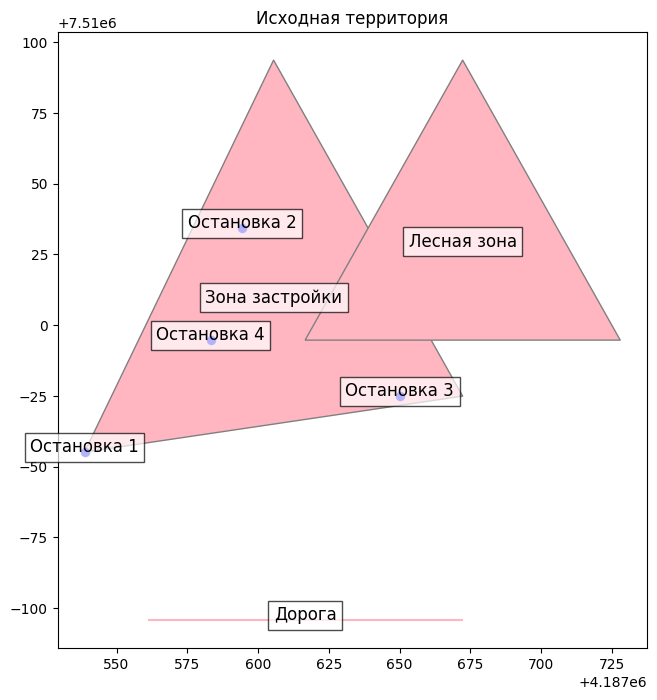

In [2]:
'''1. Загрузка и подготовка данных'''

# Загружаем config.json
with open("config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

# Загружаем GeoJSON
gdf = gpd.read_file("area.geojson")

# Переводим в систему координат EPSG:4326 (WGS 84) — долгота/широта
gdf = gdf.set_crs("EPSG:4326")

# Преобразуем в метры (Web Mercator)
gdf = gdf.to_crs("EPSG:3857")

# Проверяем площадь после преобразования
print(f"Площадь зоны застройки после преобразования: {gdf[gdf['name'] == 'Зона застройки'].geometry.iloc[0].area:.2f} м²")

# Фильтруем точки (остановки) по типу геометрии
stops_gdf = gdf[gdf.geometry.type == "Point"]

# Визуализация территории
fig, ax = plt.subplots(figsize=(8, 8)) # создаем фигуру и ось
gdf.plot(ax=ax, color="lightpink", edgecolor="gray")
stops_gdf.plot(ax=ax, color="blue", markersize=30, label="Остановки ОТ")
# Добавляем подписи к объектам
for idx, row in gdf.iterrows():  
    centroid = row["geometry"].centroid  # находим центр геометрии
    ax.text(centroid.x, centroid.y, row["name"], fontsize=12, ha="center",
            bbox=dict(facecolor="white", alpha=0.7))  # подписываем участок
plt.title("Исходная территория")
plt.show()

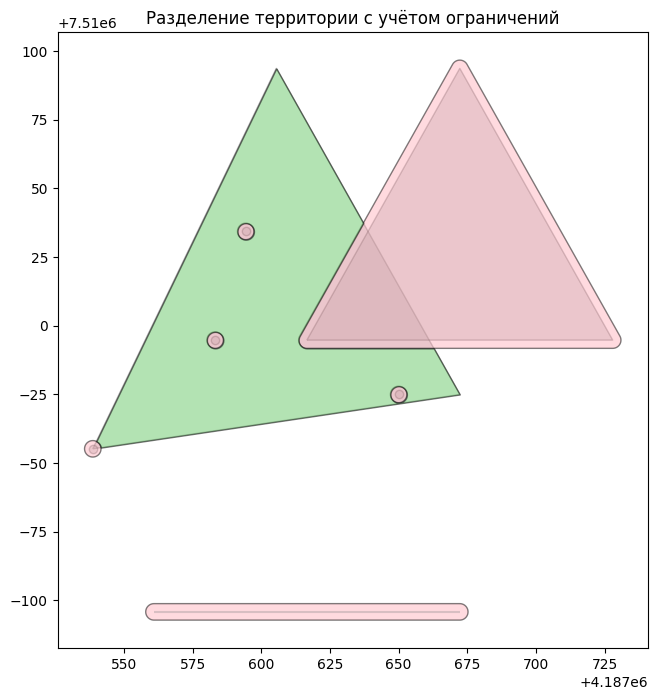

In [3]:
'''2. Формирование буферных зон'''

# Добавляем буферы - область вокруг объекта, которая создаётся на определённом расстоянии
min_distance = config["min_distance"] 
gdf["buffer"] = gdf.apply(
    lambda row: row.geometry.buffer(min_distance) if row.get("restriction") == "no_build" else row.geometry,
    axis=1
)
buffer_gdf = gdf[gdf["restriction"] == "no_build"][["buffer", "name"]]
buffer_gdf = buffer_gdf.rename(columns={"buffer": "geometry"})  # GeoDataFrame должен содержать "geometry"

# Объединяем все буферные зоны в одну
restricted_area = buffer_gdf.union_all().buffer(0)

# Определяем зону застройки, вычитая из нее буфер запрещенной зоны
buildable_area = gdf[gdf["name"] == "Зона застройки"].geometry.iloc[0].difference(restricted_area)

# Визуализация
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color="gray", edgecolor="black", alpha=0.3)  # Исходные объекты
buffer_gdf.plot(ax=ax, color="lightpink", alpha=0.5, edgecolor="black")  # Запрещённые зоны
gpd.GeoSeries([buildable_area]).plot(ax=ax, color="lightgreen", alpha=0.5, edgecolor="black")  # Разрешённая зона

plt.title("Разделение территории с учётом ограничений")
plt.show()

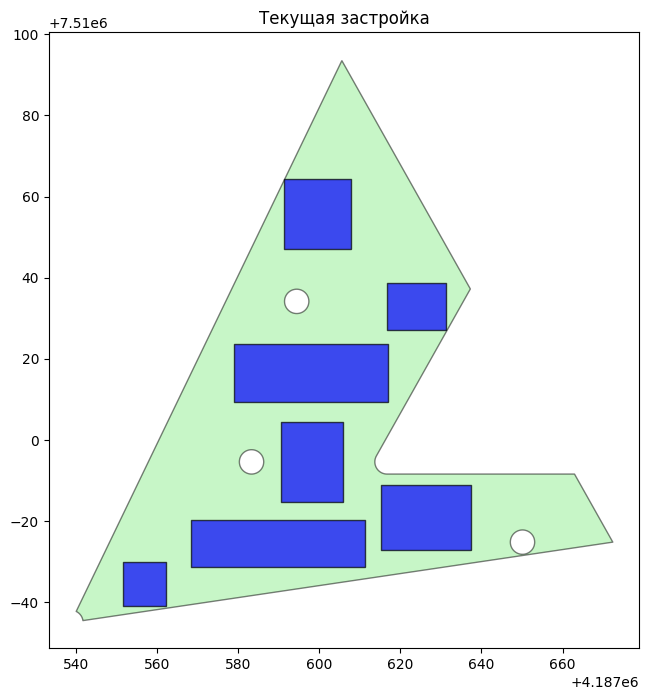

In [4]:
'''3. Генерация зданий и визуализация промежуточного этапа'''

# Функция генерации одного здания
def generate_building(buildable_area, min_size, max_size):
    attempts = 0
    while attempts < 100: # Ограничиваем количество попыток
        minx, miny, maxx, maxy = buildable_area.bounds 
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        width = random.uniform(min_size, max_size)
        height = random.uniform(min_size, max_size)
        building = box(x, y, x + width, y + height)
        if buildable_area.contains(building): # Проверяем, что здание полностью находится в зоне застройки
            return building
        attempts += 1
    return None

# Функция генерации нескольких зданий
def generate_buildings(buildable_area, min_size, max_size, min_distance, density_limit):
    buildings = []
    total_area = buildable_area.area
    built_area = 0
    while built_area / total_area < density_limit: # Генерируем здания, пока не достигнем заданной плотности застройки
        new_building = generate_building(buildable_area, min_size, max_size)
        if new_building and all(new_building.distance(b) >= min_distance for b in buildings): # Проверяем минимальное расстояние между зданиями
            buildings.append(new_building)
            built_area += new_building.area
    return buildings

# Функция для визуализации застройки без учета доступности
def plot_buildings(buildings, buildable_area):
    fig, ax = plt.subplots(figsize=(8, 8))
    gpd.GeoSeries([buildable_area]).plot(ax=ax, color="lightgreen", alpha=0.5, edgecolor="black")
    gpd.GeoSeries(buildings).plot(ax=ax, color="blue", alpha=0.7, edgecolor="black")
    plt.title("Текущая застройка")
    plt.show()

# Начальная генерация застройки
current_buildings = generate_buildings(buildable_area, config["min_size"], config["max_size"], config["min_distance"], config["density_limit"])
plot_buildings(current_buildings, buildable_area)

In [5]:
'''4. Реализация учета доступности общественного транспорта'''

# Расчет расстояний до ближайшей остановки
def distance_to_nearest_stop(building, stops):
    return min(building.distance(stop) for stop in stops)

def calculate_transport_accessibility(buildings, stops):
    distances = [distance_to_nearest_stop(building, stops.geometry) for building in buildings]
    max_dist = max(distances)
    min_dist = min(distances)
    # Задаем цвета: наименьшие значения - зеленые, наибольшие - красные
    colors = [plt.cm.RdYlGn(1 - (dist - min_dist) / (max_dist - min_dist) if max_dist != min_dist else 1) for dist in distances]
    return distances, colors

# Визуализация застройки с учетом доступности ОТ
def plot_buildings_with_heatmap(buildings, area, stops):
    distances, colors = calculate_transport_accessibility(buildings, stops)
    fig, ax = plt.subplots(figsize=(8, 8))
    gpd.GeoSeries([area]).plot(ax=ax, color="lightgreen", alpha=0.5, edgecolor="black")
    
    for building, color, dist in zip(buildings, colors, distances): 
        gpd.GeoSeries([building]).plot(ax=ax, color=color, alpha=0.7, edgecolor="black")
        ax.annotate(f'{dist:.1f} m', xy=(building.centroid.x, building.centroid.y), fontsize=8, ha='center')
    
    stops.plot(ax=ax, color="red", markersize=30, label="Остановки ОТ")
    plt.legend()
    plt.title("Застройка с учетом доступности ОТ")
    plt.show()

In [7]:
'''5. Функция сохранения данных в GeoJSON и PNG'''

def save_buildings(buildings, buildable_area): 
    buildings_gdf = gpd.GeoDataFrame(geometry=buildings, crs="EPSG:3857")
    timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S") # Добавляем временную метку для удобства различения файлов
    
    # Сохранение GeoJSON
    geojson_dir = Path.cwd() / "buildings_geojson" 
    geojson_dir.mkdir(parents=True, exist_ok=True)
    geojson_path = geojson_dir / f"buildings_{timestamp}.geojson" 
    buildings_gdf.to_file(geojson_path, driver="GeoJSON")
    print(f"Данные сохранены в файл: {geojson_path}")
    
    # Сохранение PNG
    png_dir = Path.cwd() / "buildings_png"
    png_dir.mkdir(parents=True, exist_ok=True)
    png_path = png_dir / f"buildings_{timestamp}.png"
    fig, ax = plt.subplots(figsize=(8, 8))
    gpd.GeoSeries([buildable_area]).plot(ax=ax, color="lightgreen", alpha=0.5, edgecolor="black")
    gpd.GeoSeries(buildings).plot(ax=ax, color="blue", alpha=0.7, edgecolor="black")
    plt.title("Текущая застройка")
    plt.savefig(png_path)
    plt.close(fig)
    print(f"График сохранён как {png_path}")

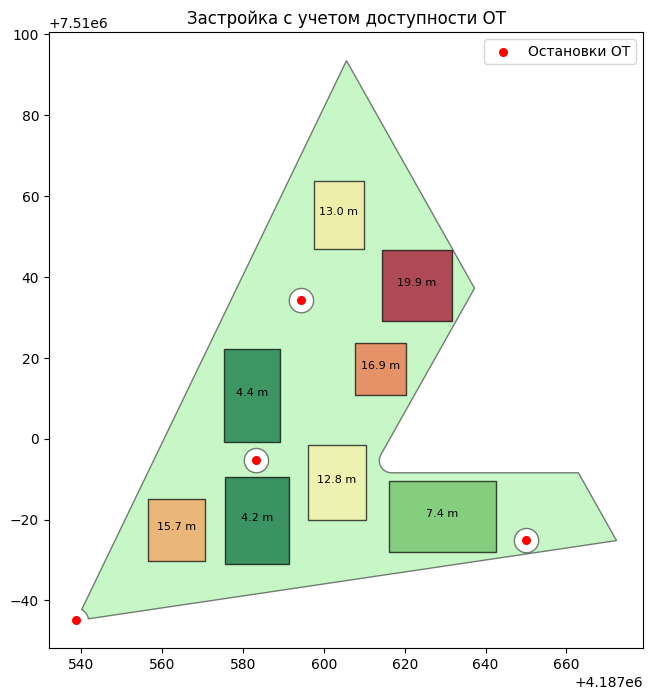

In [ ]:
'''6. Интерфейс и обновление данных. Финальная карта'''

# Кнопка для обновления застройки
def regenerate_buildings(_):
    global current_buildings
    current_buildings = generate_buildings(buildable_area, config["min_size"], config["max_size"], config["min_distance"], config["density_limit"])
    plot_buildings_with_heatmap(current_buildings, buildable_area, stops_gdf)

# Кнопка для сохранения данных
def save_current_buildings(_):
    save_buildings(current_buildings, buildable_area)

# Интерфейс
refresh_button = Button(description="Добавить вариант застройки")
refresh_button.on_click(regenerate_buildings)
save_button = Button(description="Сохранить застройку")
save_button.on_click(save_current_buildings)

# Отображение кнопок
ui = VBox([refresh_button, save_button]) 
display(ui)

# Финальная генерация застройки
current_buildings = generate_buildings(buildable_area, config["min_size"], config["max_size"], config["min_distance"], config["density_limit"])
plot_buildings_with_heatmap(current_buildings, buildable_area, stops_gdf)